## Packages


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple
import sys
from pathlib import Path
from datetime import datetime
import os
import pyro

# Add parent directory to path to import Models
# This works for notebooks in the Experiments folder
project_root = Path.cwd().parent if Path.cwd().name == 'Experiments' else Path.cwd()
sys.path.insert(0, str(project_root))

# Setup results directory
results_dir = project_root / "results" / "ood"
results_dir.mkdir(parents=True, exist_ok=True)
plots_dir = results_dir / "plots"
plots_dir.mkdir(exist_ok=True)
stats_dir = results_dir / "statistics"
stats_dir.mkdir(exist_ok=True)

print(f"Results will be saved to: {results_dir}")

# Import from Models folder
from Models.MC_Dropout import (
    MCDropoutRegressor,
    train_model,
    mc_dropout_predict,
    gaussian_nll,
    beta_nll,
    plot_toy_data,
    plot_uncertainties,
    normalize_x,
    normalize_x_data
)

from Models.Deep_Ensemble import (
    train_ensemble_deep,
    ensemble_predict_deep
)

from Models.BNN import (
    train_bnn,
    bnn_predict,
    normalize_x as bnn_normalize_x,
    normalize_x_data as bnn_normalize_x_data
)

from Models.BAMLSS import (
    fit_bamlss,
    bamlss_predict
)

from utils.device import get_device
from utils.plotting import plot_toy_data, plot_uncertainties_ood
import utils.results_save as results_save_module
from utils.results_save import save_plot, save_statistics, save_summary_text, save_summary_statistics
from utils.plotting import plot_data_with_ood_regions

# Import helper functions for OOD experiments
from utils.ood_experiments import (
    run_mc_dropout_ood_experiment,
    run_deep_ensemble_ood_experiment,
    run_bnn_ood_experiment,
    run_bamlss_ood_experiment
)

# Set the module-level directories for results_save
results_save_module.plots_dir = plots_dir
results_save_module.stats_dir = stats_dir


Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Results will be saved to: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood
CUDA not available. Using CPU.
CUDA not available. Using CPU.


## Device Setup


In [2]:
device = get_device()


CUDA not available. Using CPU.


## Generate Toy Datasets


In [3]:
# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ----- Data generation for linear function with homo/heteroscedastic noise -----
# f(x) = 0.7x + 0.5
# noise_type: 'homoscedastic' (σ(x) = 0.20) or 'heteroscedastic' (σ(x) = 0.10 + 0.2(0.5 + 0.5sin(x)))
def generate_toy_regression(n_train=1000, train_range=(-5, 10.0), train_ranges=None,
                           ood_ranges=None, grid_points=1000, noise_type='heteroscedastic', type = "linear"):
    """
    Generate toy regression data with support for multiple training ranges and OOD regions.
    
    Args:
        n_train: Number of training samples
        train_range: Single training range tuple (min, max) - for backward compatibility
        train_ranges: List of training range tuples [(min1, max1), (min2, max2), ...]
                     If provided, overrides train_range. Samples are distributed proportionally.
        ood_ranges: List of OOD range tuples [(min1, max1), (min2, max2), ...]
                   If None, OOD is automatically everything NOT in training ranges
        grid_points: Number of grid points for evaluation
        noise_type: 'homoscedastic' or 'heteroscedastic'
        type: 'linear' or 'sin'
    
    Returns:
        (x_train, y_train, x_grid, y_grid_clean, ood_mask)
    """
    # Handle train_ranges: if provided, use it; otherwise use train_range as single range
    if train_ranges is None:
        train_ranges = [train_range]
    else:
        # train_ranges provided, ignore train_range
        pass
    
    # Sample training data proportionally from each training range
    # Calculate total width of all training ranges
    total_width = sum([r[1] - r[0] for r in train_ranges])
    
    # Sample from each range proportionally
    x_train_list = []
    samples_allocated = 0
    for idx, train_r in enumerate(train_ranges):
        low, high = train_r
        range_width = high - low
        # Number of samples proportional to range width
        if idx == len(train_ranges) - 1:
            # Last range gets remaining samples to ensure exact total
            n_samples = n_train - samples_allocated
        else:
            n_samples = int(n_train * range_width / total_width)
            samples_allocated += n_samples
        x_train_range = np.random.uniform(low, high, size=(n_samples, 1))
        x_train_list.append(x_train_range)
    
    x_train = np.vstack(x_train_list)
    # Shuffle to mix samples from different ranges
    indices = np.random.permutation(len(x_train))
    x_train = x_train[indices]
    
    if type == "linear":
        # Linear function: f(x) = 0.7x + 0.5
        f_clean = lambda x: 0.7 * x + 0.5
        y_clean_train = f_clean(x_train)
    elif type == "sin":
        f_clean = lambda x:  x * np.sin(x) + x
        y_clean_train = f_clean(x_train)
    else:
        raise ValueError("type must be 'linear', 'sin'")

    # Define noise variance σ²(x)
    if noise_type == 'homoscedastic':
        # Homoscedastic: σ(x) = 0.8
        sigma = 2
        sigma_train = np.full_like(x_train, sigma)
    elif noise_type == 'heteroscedastic':
        # Heteroscedastic: 
        sigma_train = np.abs(2.5 * np.sin(0.5*x_train +5))
    else:
        raise ValueError("noise_type must be 'homoscedastic' or 'heteroscedastic'")
    
    # Generate noise: ε | x ~ N(0, σ²(x))
    epsilon = np.random.normal(0.0, sigma_train, size=(n_train, 1))
    y_train = y_clean_train + epsilon

    # Determine grid extent: from min of all training/OOD ranges to max
    all_ranges = train_ranges + (ood_ranges if ood_ranges else [])
    grid_start = min([r[0] for r in all_ranges])
    grid_end = max([r[1] for r in all_ranges])
    
    # Dense evaluation grid spanning all training and OOD regions
    x_grid = np.linspace(grid_start, grid_end, grid_points).reshape(-1, 1)
    y_grid_clean = f_clean(x_grid)
    
    # Create OOD mask: True for points NOT in any training range
    # Everything outside training ranges is OOD (including gaps and explicit OOD ranges)
    ood_mask = np.ones(len(x_grid), dtype=bool)  # Start with all True (OOD)
    
    # Mark training ranges as ID (False in ood_mask)
    for train_r in train_ranges:
        train_start, train_end = train_r
        train_mask = (x_grid[:, 0] >= train_start) & (x_grid[:, 0] <= train_end)
        ood_mask[train_mask] = False  # Training regions are ID, not OOD
    
    # If explicit ood_ranges provided, ensure they are marked as OOD
    # (they might already be OOD if they're gaps, but this ensures they're marked)
    if ood_ranges is not None:
        for ood_range in ood_ranges:
            ood_start, ood_end = ood_range
            ood_mask |= (x_grid[:, 0] >= ood_start) & (x_grid[:, 0] <= ood_end)

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32), ood_mask)


In [ ]:
# Polynomial function with homoscedastic noise
x_train_homo, y_train_homo, x_grid_homo, y_clean_homo, ood_mask_homo = generate_toy_regression(
    n_train=1000, 
    train_range=(-5,10), 
    ood_ranges=[(10,15)],  # No OOD regions for basic visualization
    noise_type='homoscedastic',
    type = "sin"
)

# Polynomial function with heteroscedastic noise (default - used in most experiments)
x_train, y_train, x_grid, y_clean, ood_mask = generate_toy_regression(
    n_train = 1000, 
    train_range=(-5,10), 
    ood_ranges=[(10,15)],  # No OOD regions for basic visualization
    noise_type='heteroscedastic',
    type = "sin"
)


In [ ]:
plot_data_with_ood_regions(
        x_train, y_train, x_grid, y_clean,
        train_range=(-5, 10), ood_ranges=[(10,15)],
        title="Toy Regression Data Heteroscedastic (n=1000)", func_type='sin'
    )

### Set parameters


In [4]:
n_train = 1000
train_range = (-5, 10)
ood_ranges = [(10, 15)]  # List of (min, max) tuples for OOD regions
grid_points = 1500
seed = 42
torch.manual_seed(seed)


## MC Dropout - Homoscedastic



################################################################################
# Function Type: Linear (linear) - MC Dropout - OOD Experiment
################################################################################

Training range: (-5, 10)
OOD ranges: [(10, 15)]
Grid spans: [-5.00, 15.00]
ID points: 1125, OOD points: 375

Training model...
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 2.5398
[beta_nll] Epoch 200/700 - avg loss 2.4100
[beta_nll] Epoch 300/700 - avg loss 2.4244
[beta_nll] Epoch 400/700 - avg loss 2.4253
[beta_nll] Epoch 500/700 - avg loss 2.4853
[beta_nll] Epoch 600/700 - avg loss 2.4032
[beta_nll] Epoch 700/700 - avg loss 2.3816
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\uncertainties_ood\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_OOD_-_Variance.png


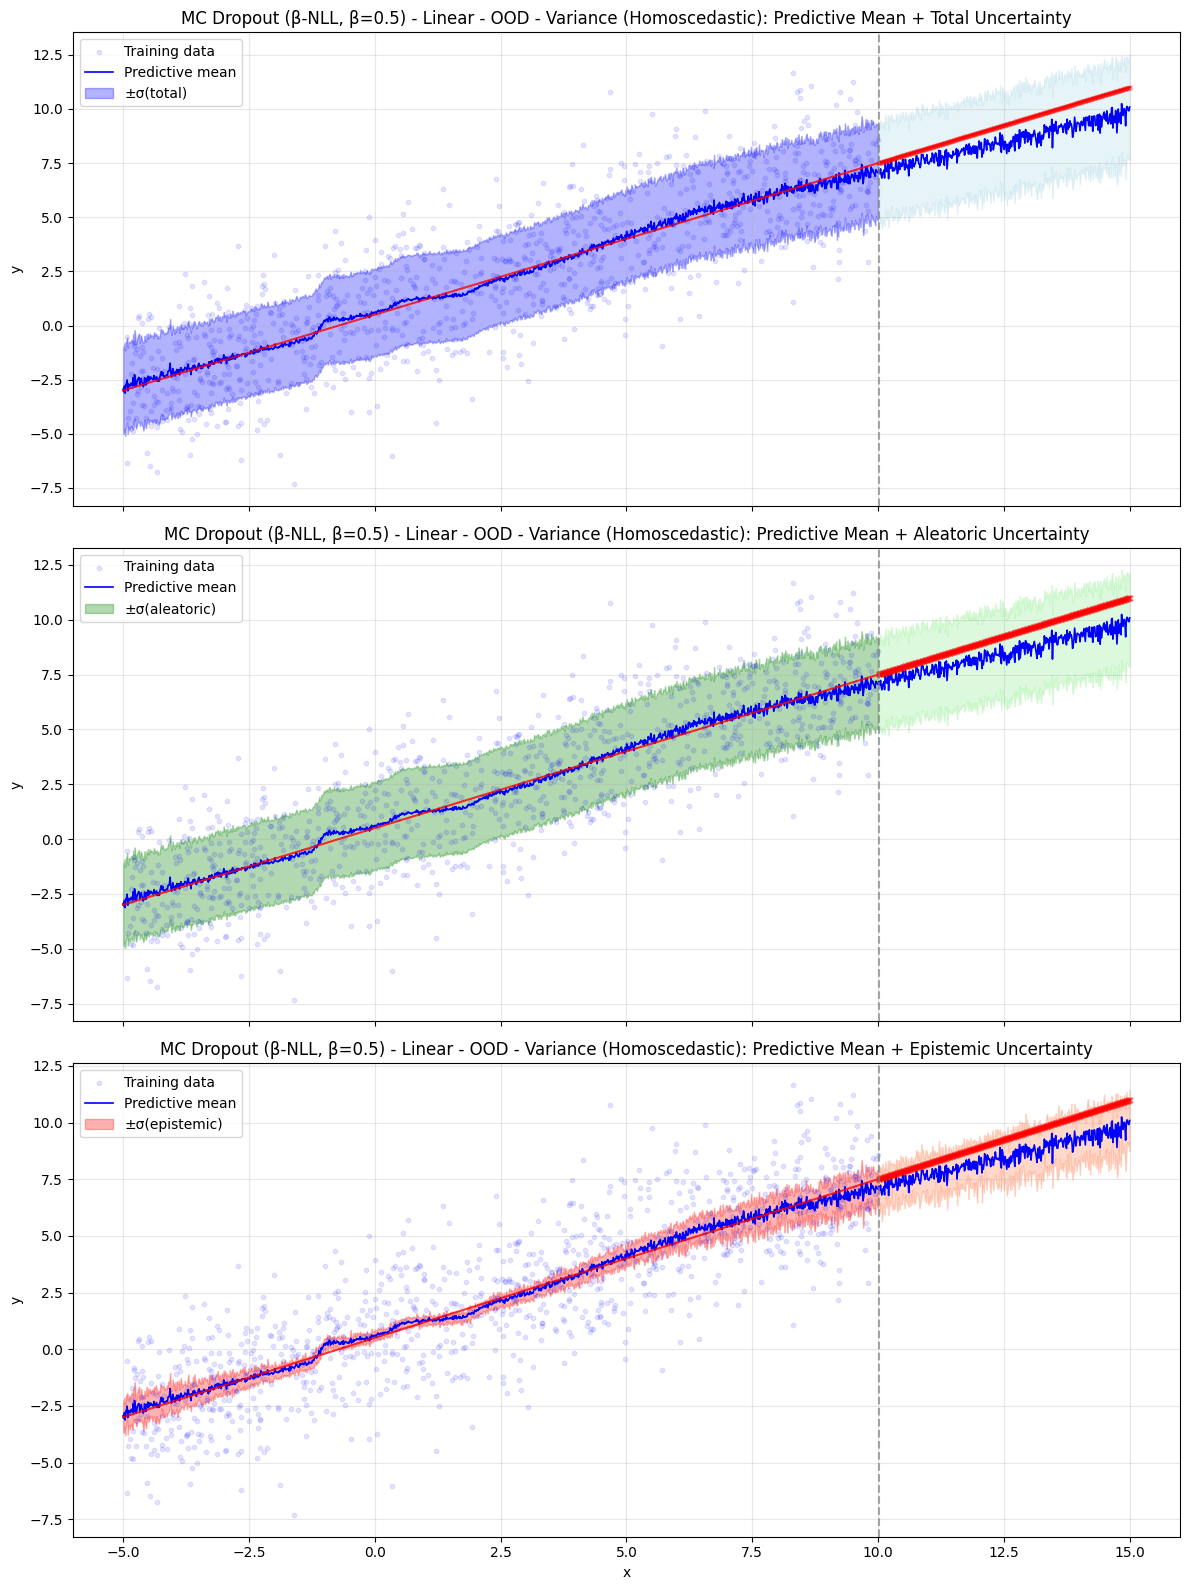

Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\uncertainties_entropy_ood\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_OOD_-_Entropy_entropy.png


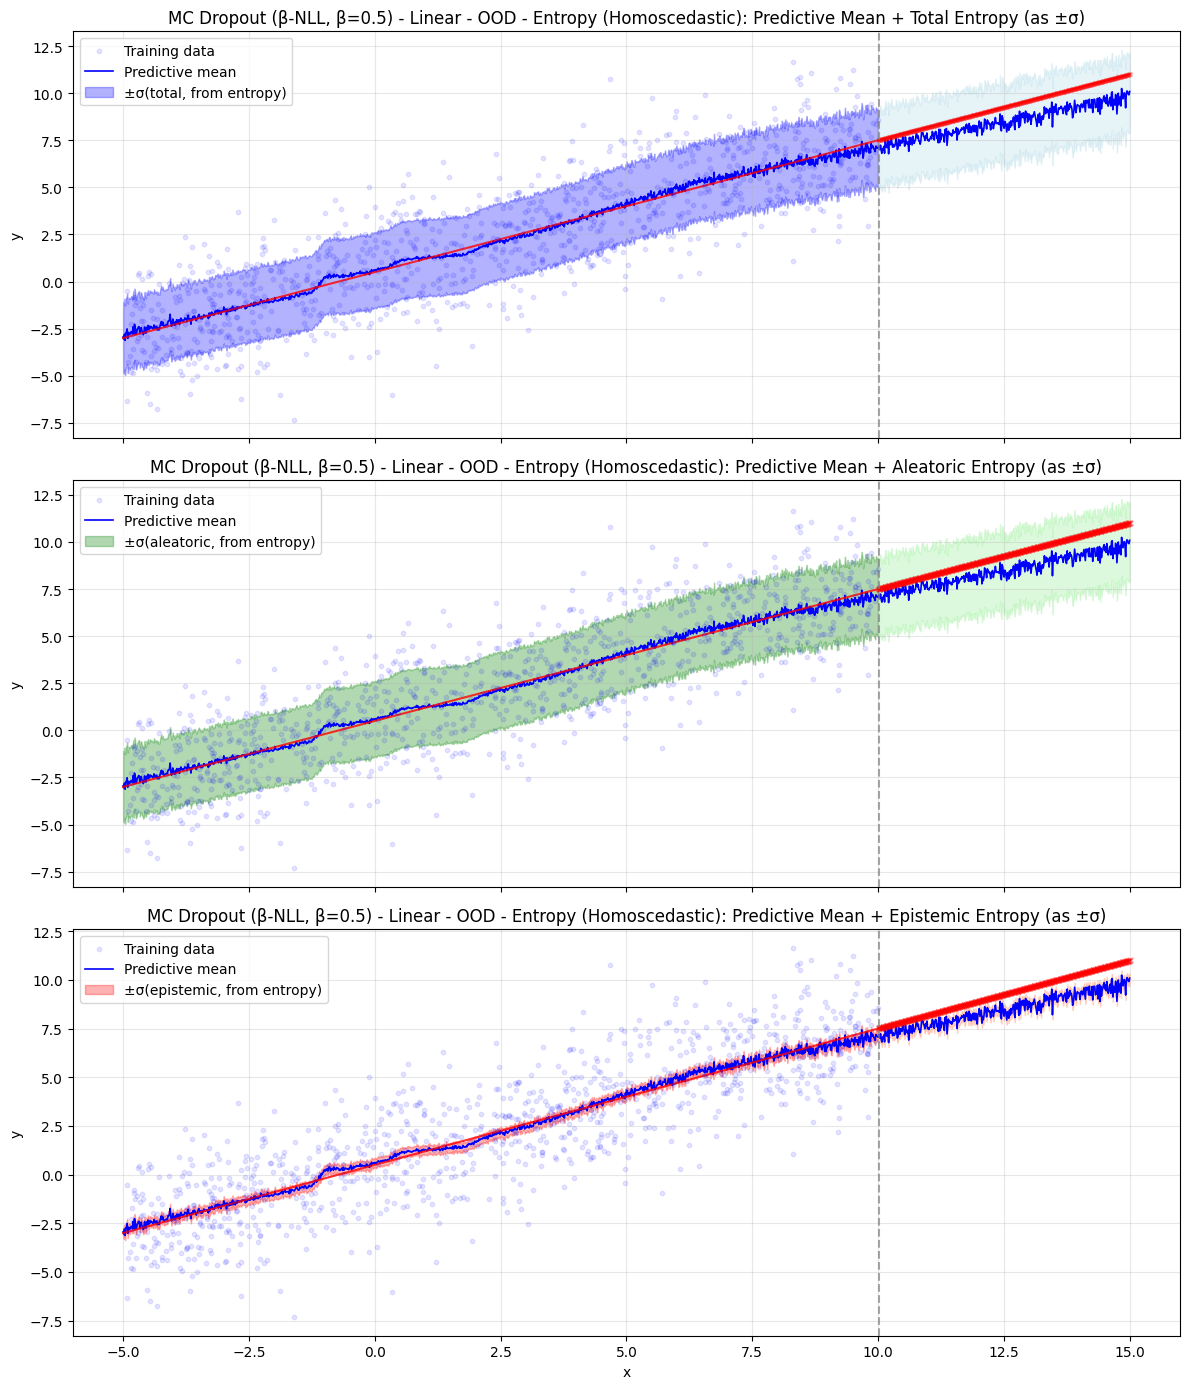


OOD Experiment Statistics - Linear Function - MC_Dropout

Region       Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
ID                           0.601731                  0.072861                  0.674592                  0.162084         0.040725
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_ID_uncertainties_summary_Linear_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_ID_uncertainties_summary_Linear_homoscedastic.xl

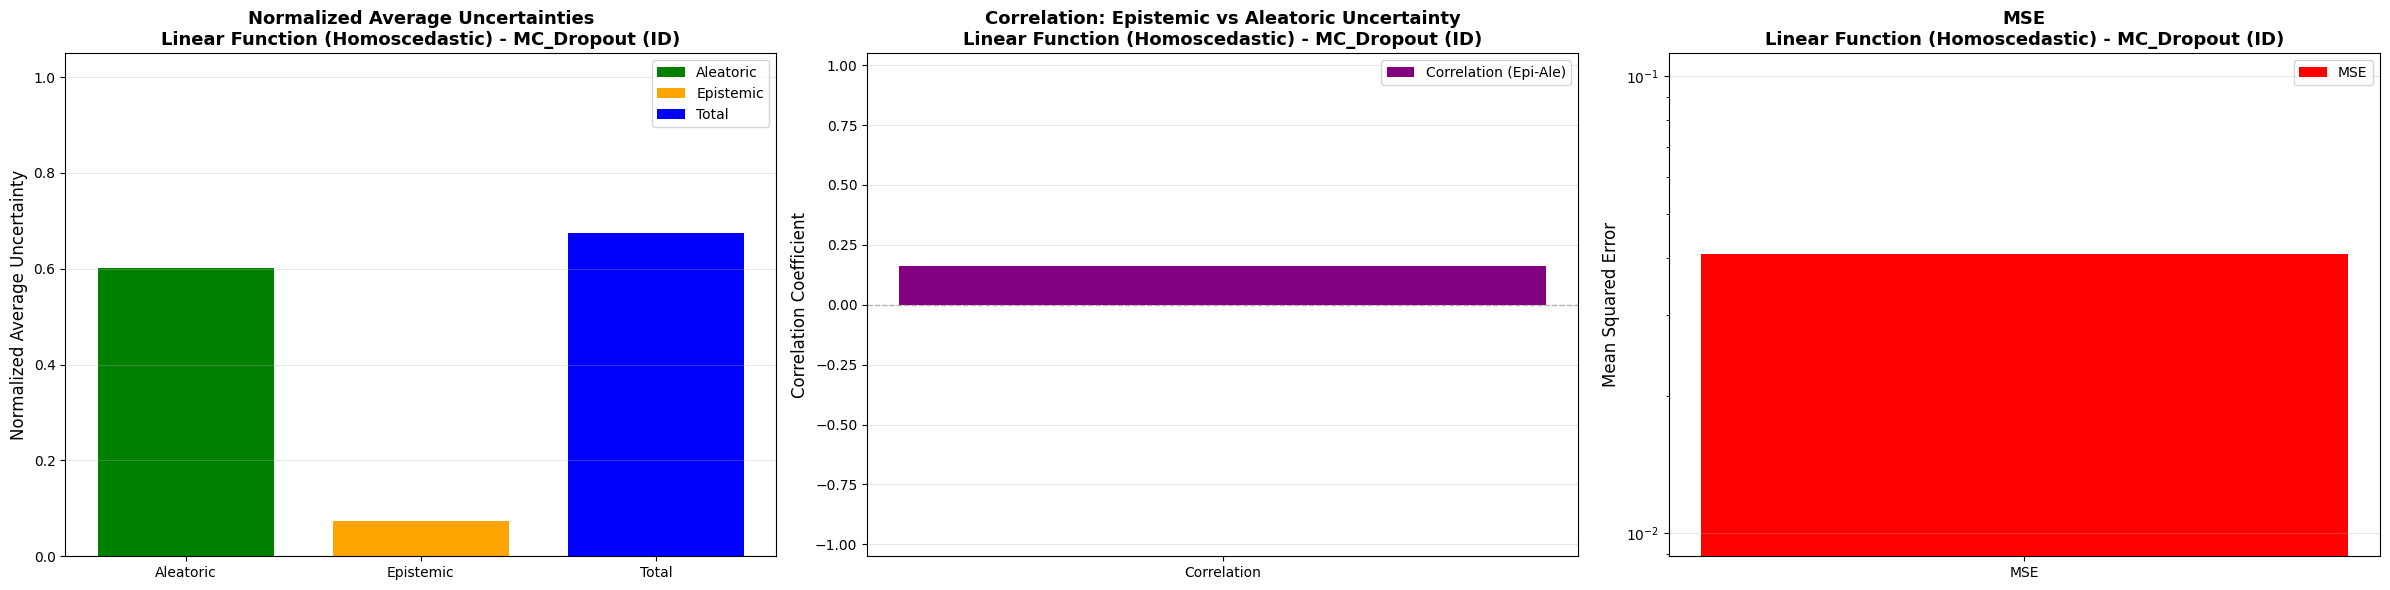

OOD                          0.810312                  0.331943                  1.142255                  0.042825         0.739081
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Linear_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Linear_homoscedastic.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Linear_homoscedastic.png


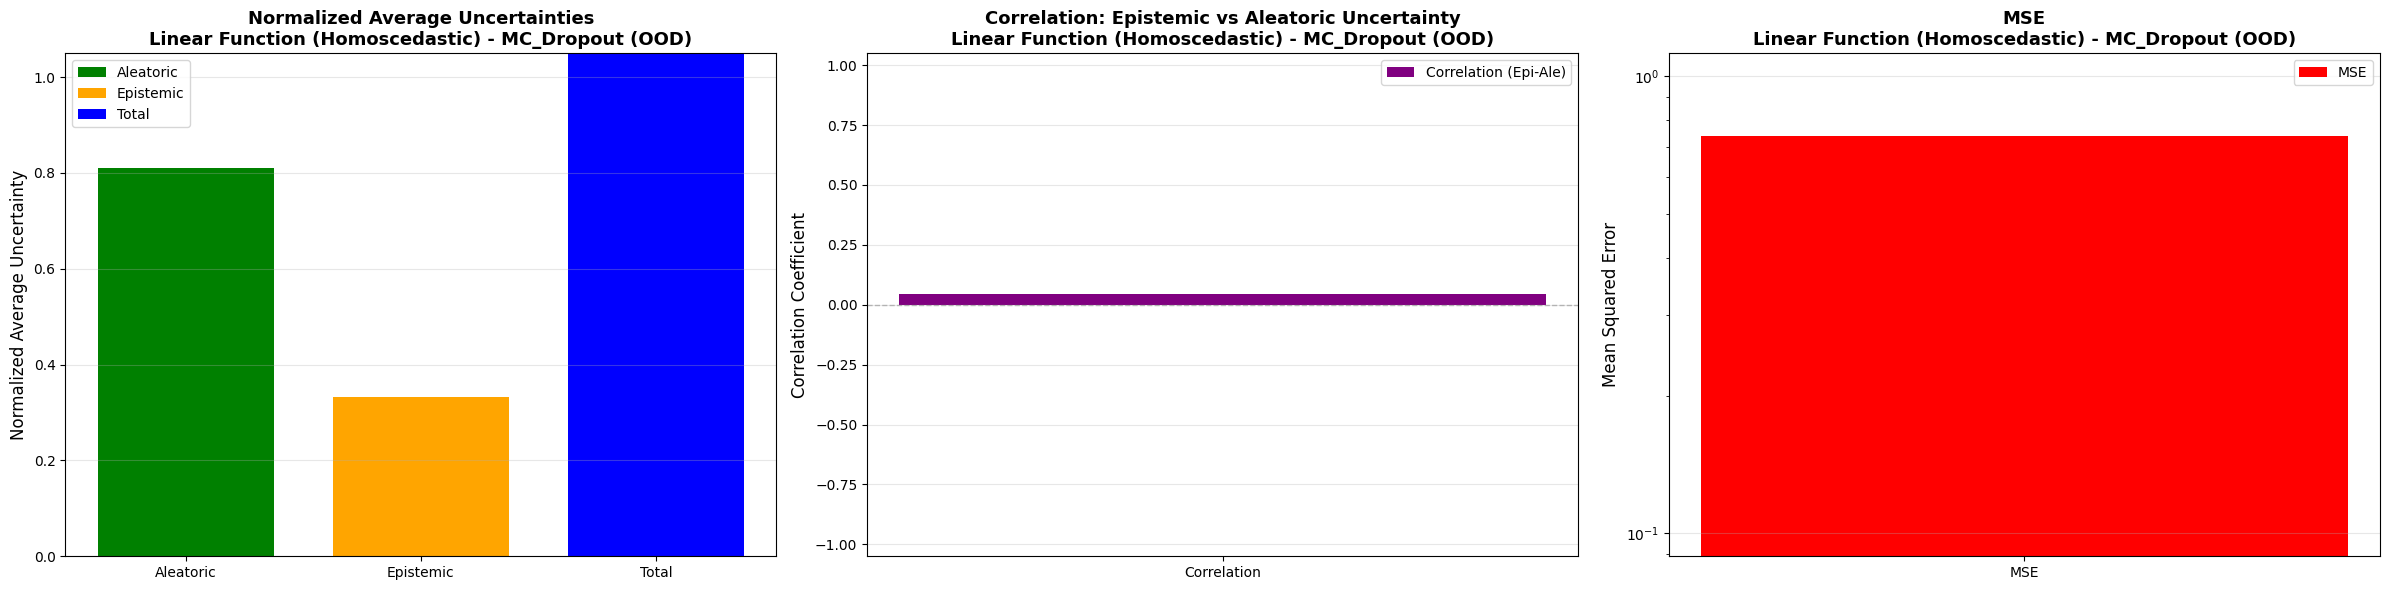

Combined                     0.653876                  0.137632                  0.791508                  0.390693         0.215314
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Linear_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Linear_homoscedastic.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Linear_homoscedastic.png


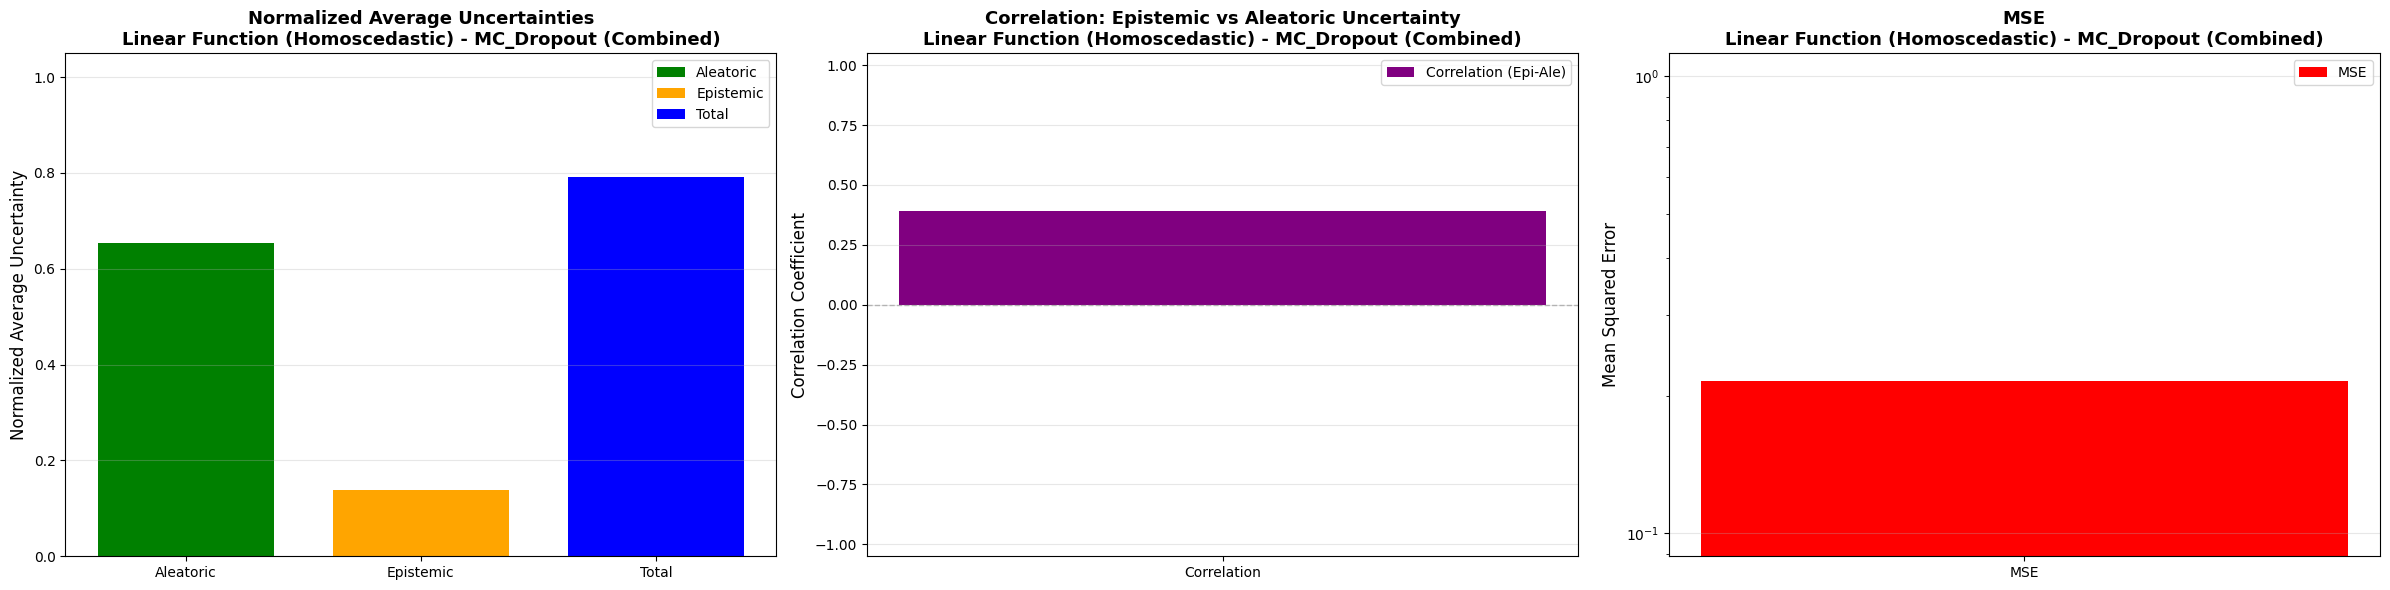


Note: Average values are normalized to [0, 1] range across all regions
      Correlation is computed on original (non-normalized) uncertainty values

OOD Experiment Statistics (Entropy) - Linear Function - MC_Dropout

Region       Avg Aleatoric (nats)      Avg Epistemic (nats)      Avg Total (nats)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
ID                           2.112409                  0.000375                  2.112784                 -0.069753         0.040725
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_ID_uncertainties_summary_Linear_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluatio

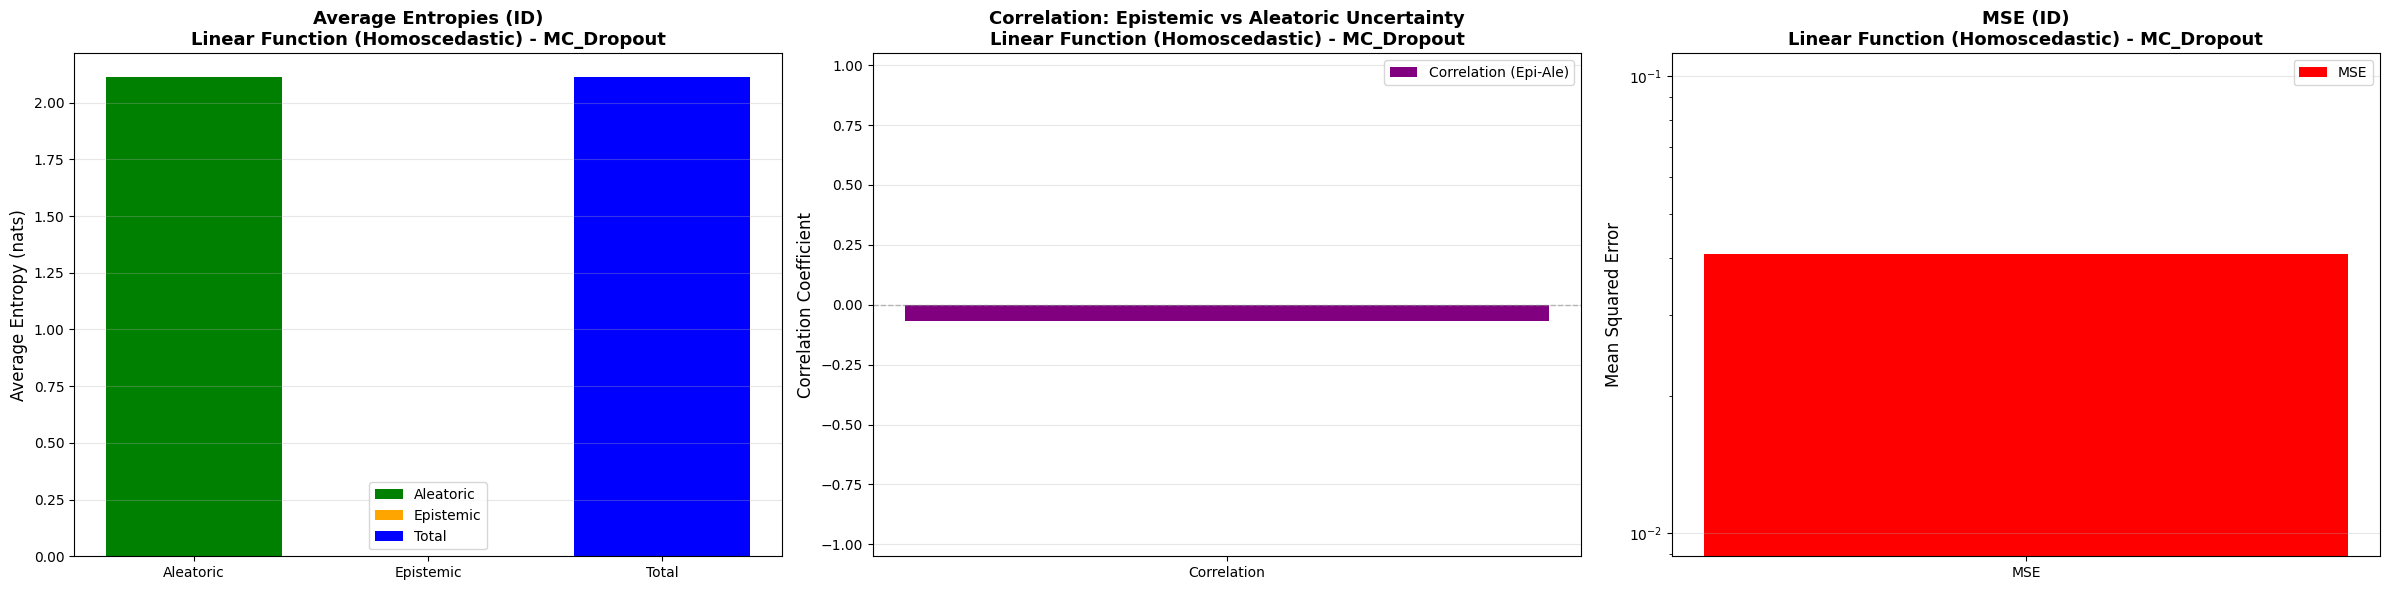

OOD                          2.137777                  0.001474                  2.139251                  0.264361         0.739081
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Linear_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Linear_homoscedastic_entropy.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Linear_homoscedastic_entropy.png


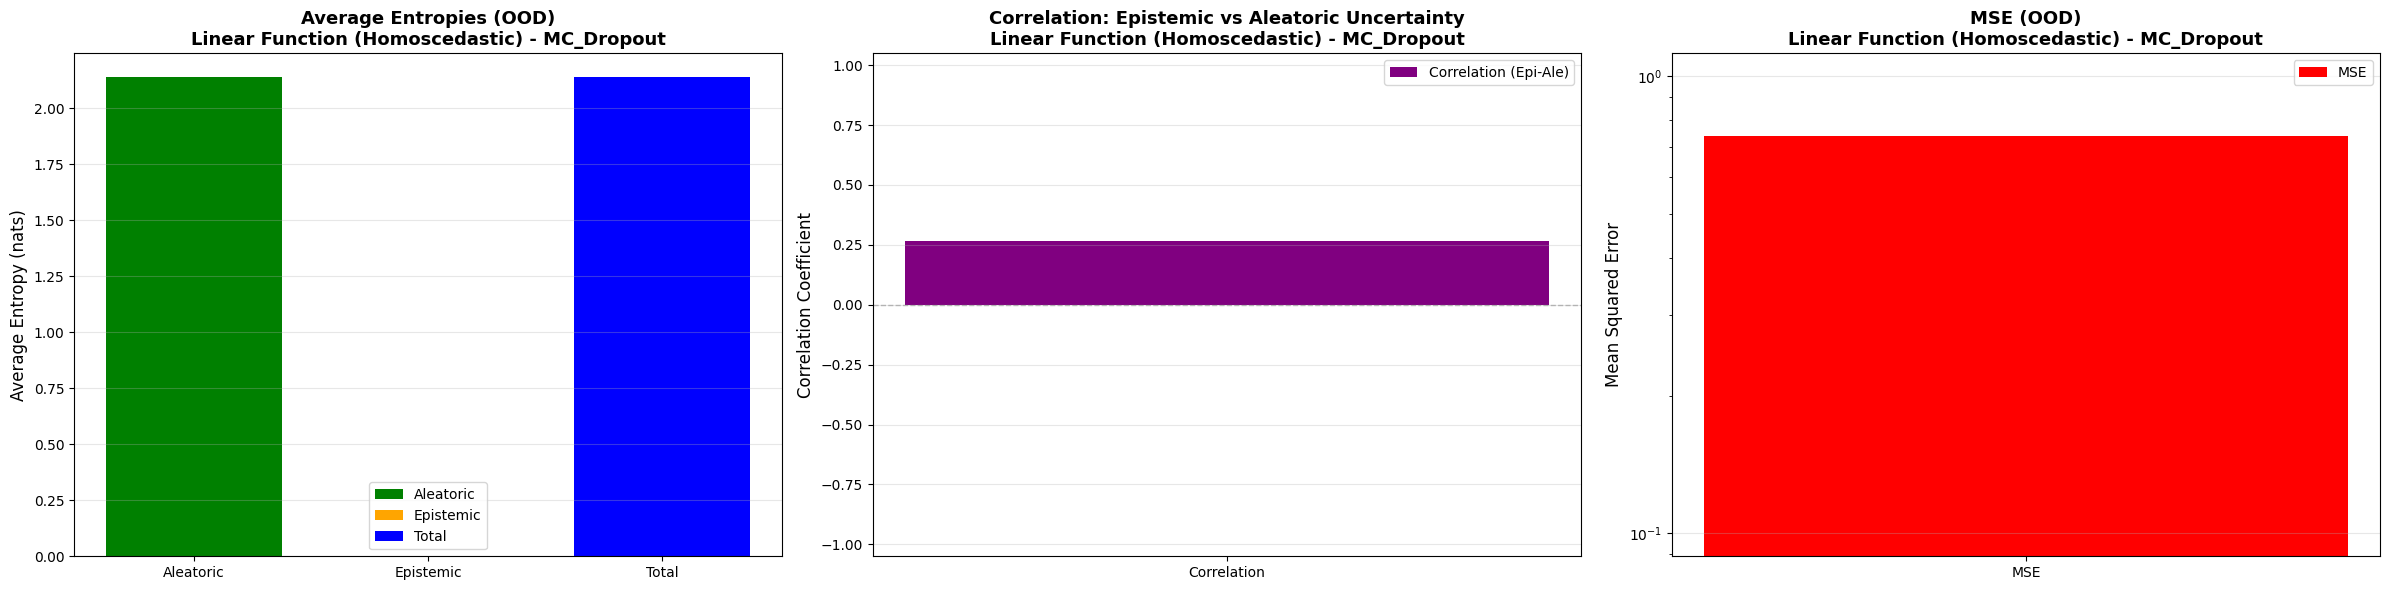

Combined                     2.118751                  0.000650                  2.119401                  0.294471         0.215314
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Linear_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Linear_homoscedastic_entropy.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\linear\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Linear_homoscedastic_entropy.png


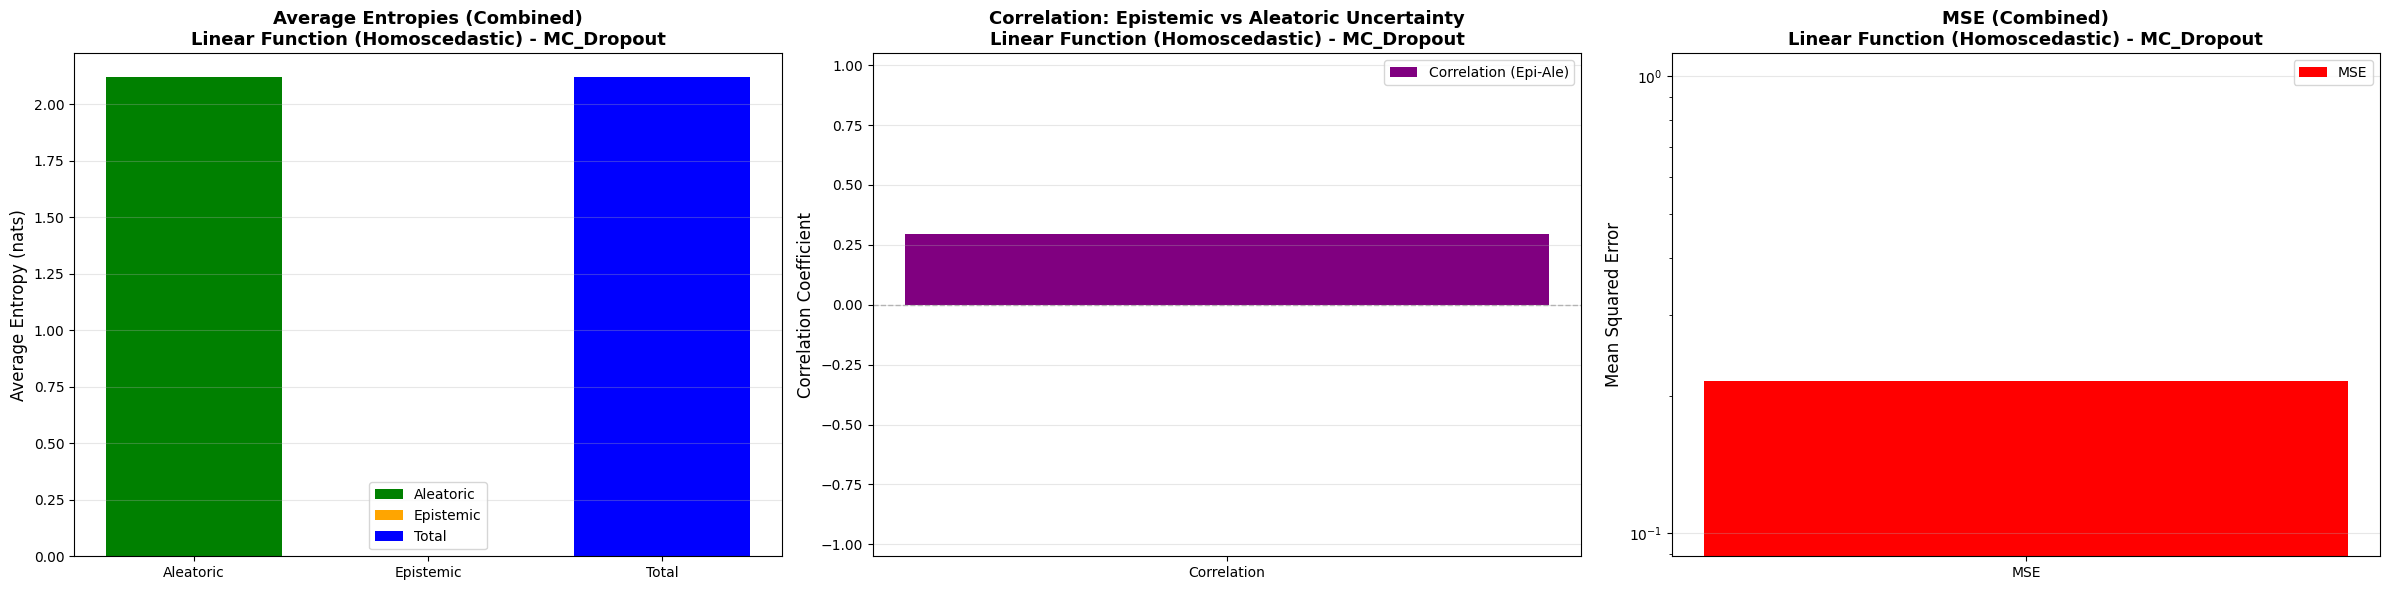


Note: Entropy values are in nats (natural logarithm base)
      Correlation is computed on entropy values

################################################################################
# Function Type: Sinusoidal (sin) - MC Dropout - OOD Experiment
################################################################################

Training range: (-5, 10)
OOD ranges: [(10, 15)]
Grid spans: [-5.00, 15.00]
ID points: 1125, OOD points: 375

Training model...
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 5.8275
[beta_nll] Epoch 200/700 - avg loss 5.2306
[beta_nll] Epoch 300/700 - avg loss 4.8686
[beta_nll] Epoch 400/700 - avg loss 4.7923
[beta_nll] Epoch 500/700 - avg loss 4.6274
[beta_nll] Epoch 600/700 - avg loss 4.4684
[beta_nll] Epoch 700/700 - avg loss 4.4727
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\uncertainties_ood\homoscedast

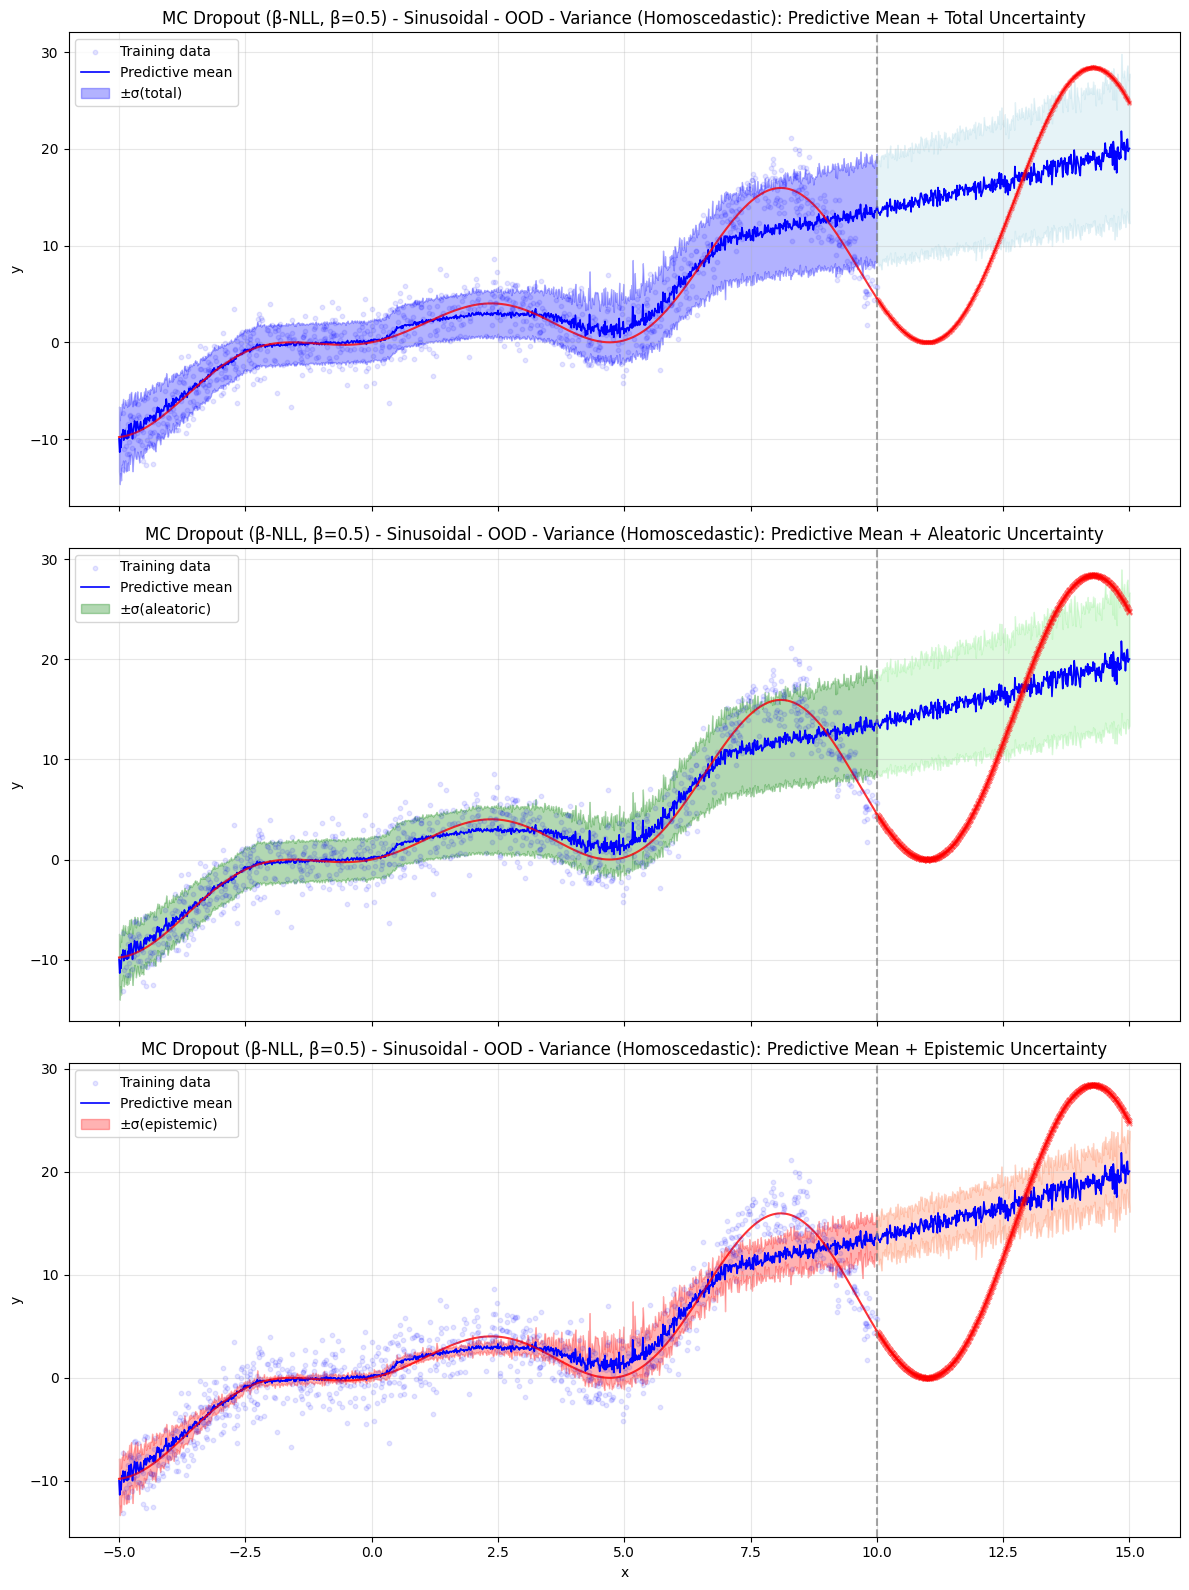

Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\uncertainties_entropy_ood\homoscedastic\sin\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_OOD_-_Entropy_entropy.png


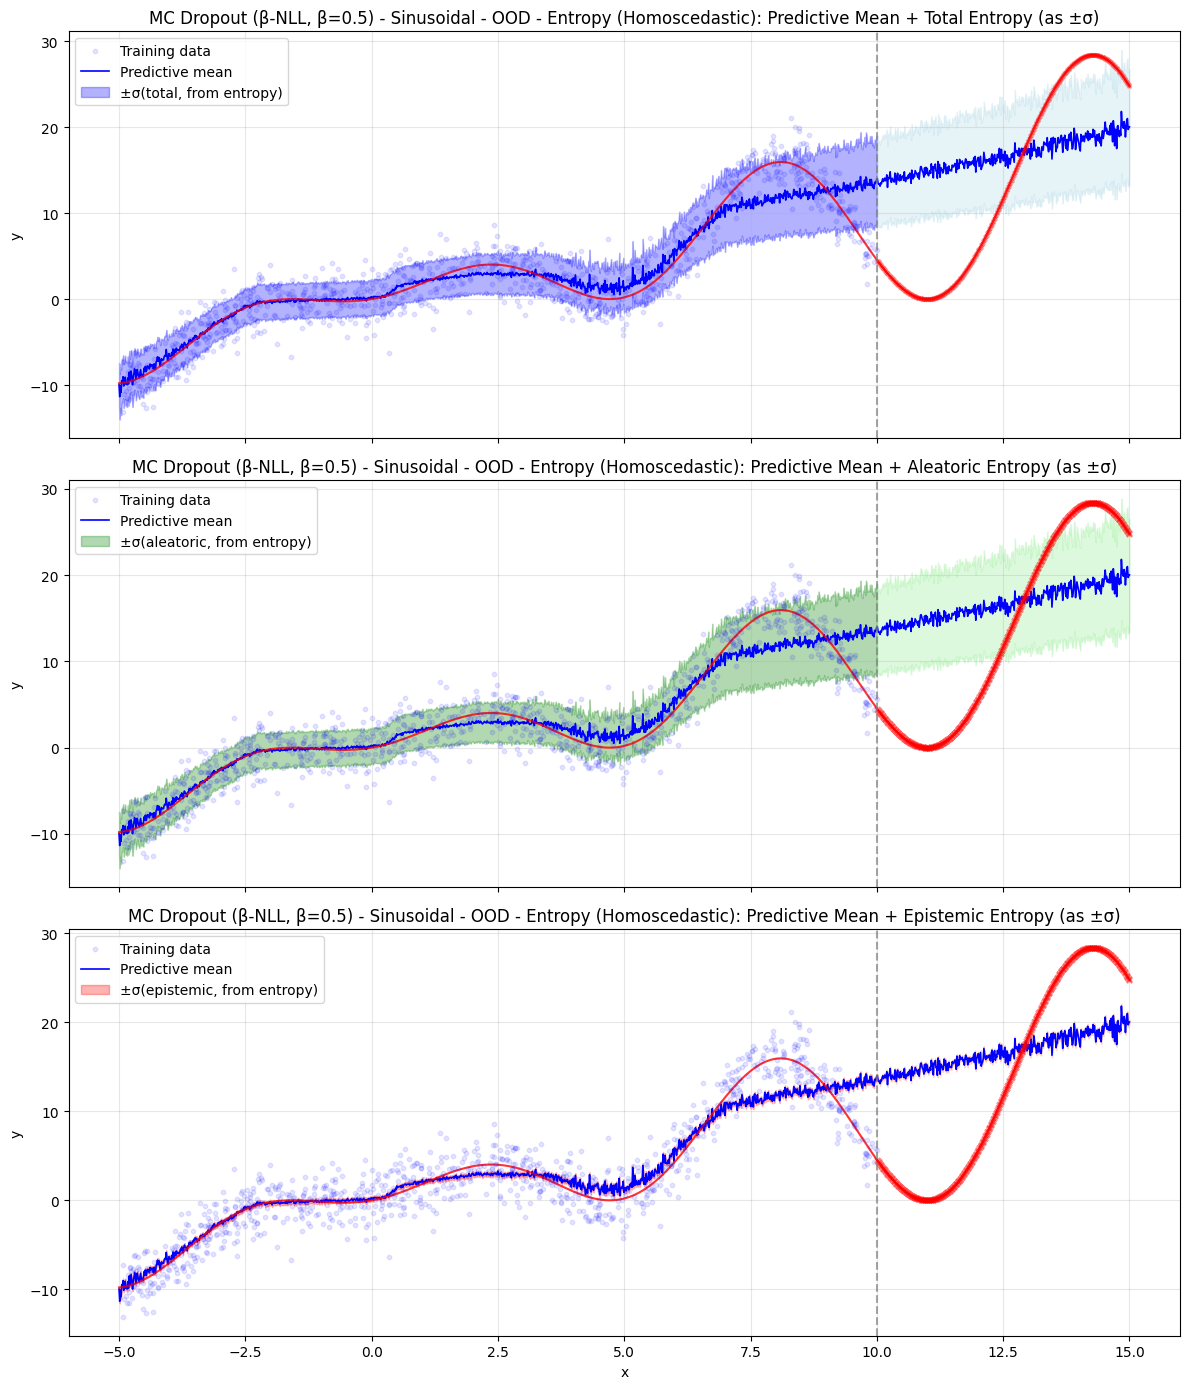


OOD Experiment Statistics - Sinusoidal Function - MC_Dropout

Region       Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
ID                           0.106778                  0.106828                  0.213606                  0.523223         3.521137
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_ID_uncertainties_summary_Sinusoidal_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_ID_uncertainties_summary_Sinusoidal_homoscedas

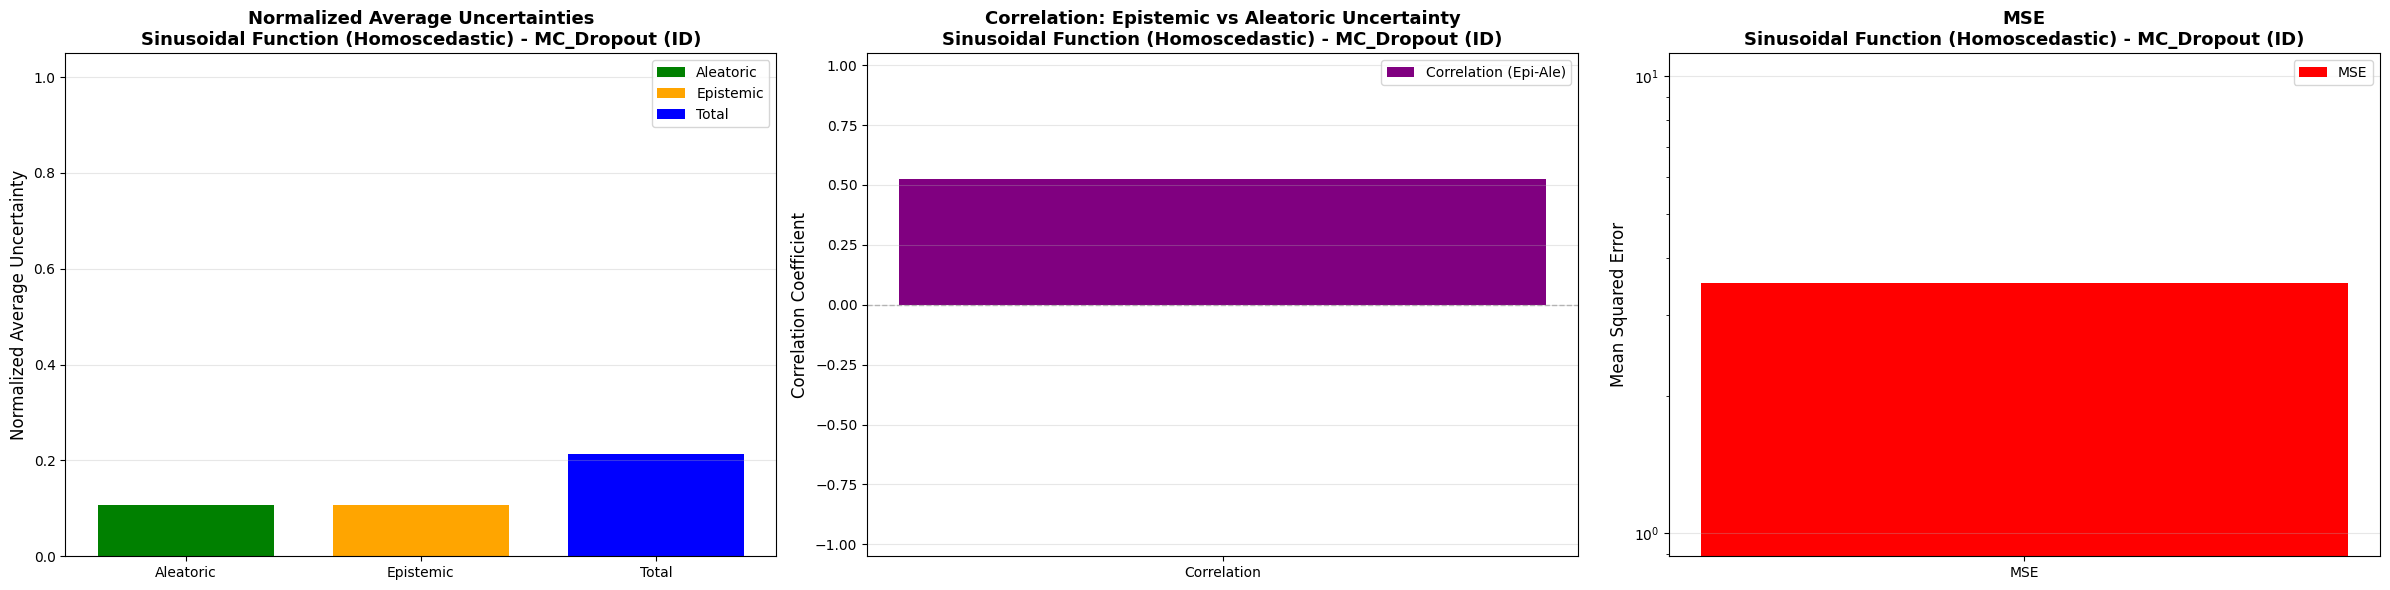

OOD                          0.631559                  0.398638                  1.030197                  0.632876        98.342804
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Sinusoidal_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Sinusoidal_homoscedastic.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Sinusoidal_homoscedastic.png


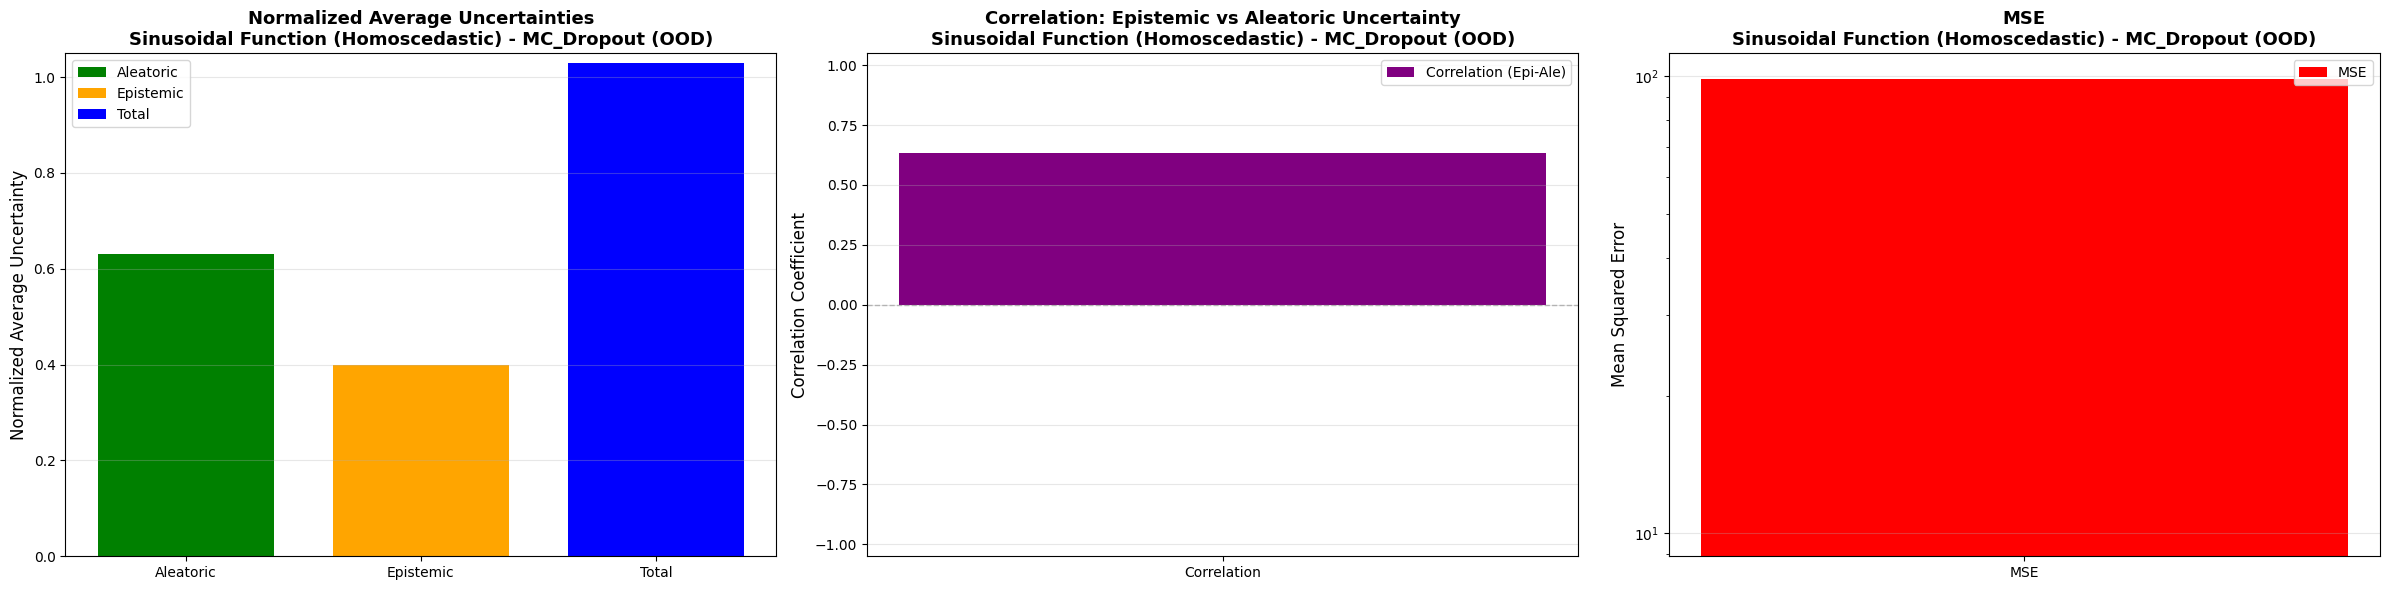

Combined                     0.237973                  0.179781                  0.417754                  0.800764        27.226553
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Sinusoidal_homoscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Sinusoidal_homoscedastic.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Sinusoidal_homoscedastic.png


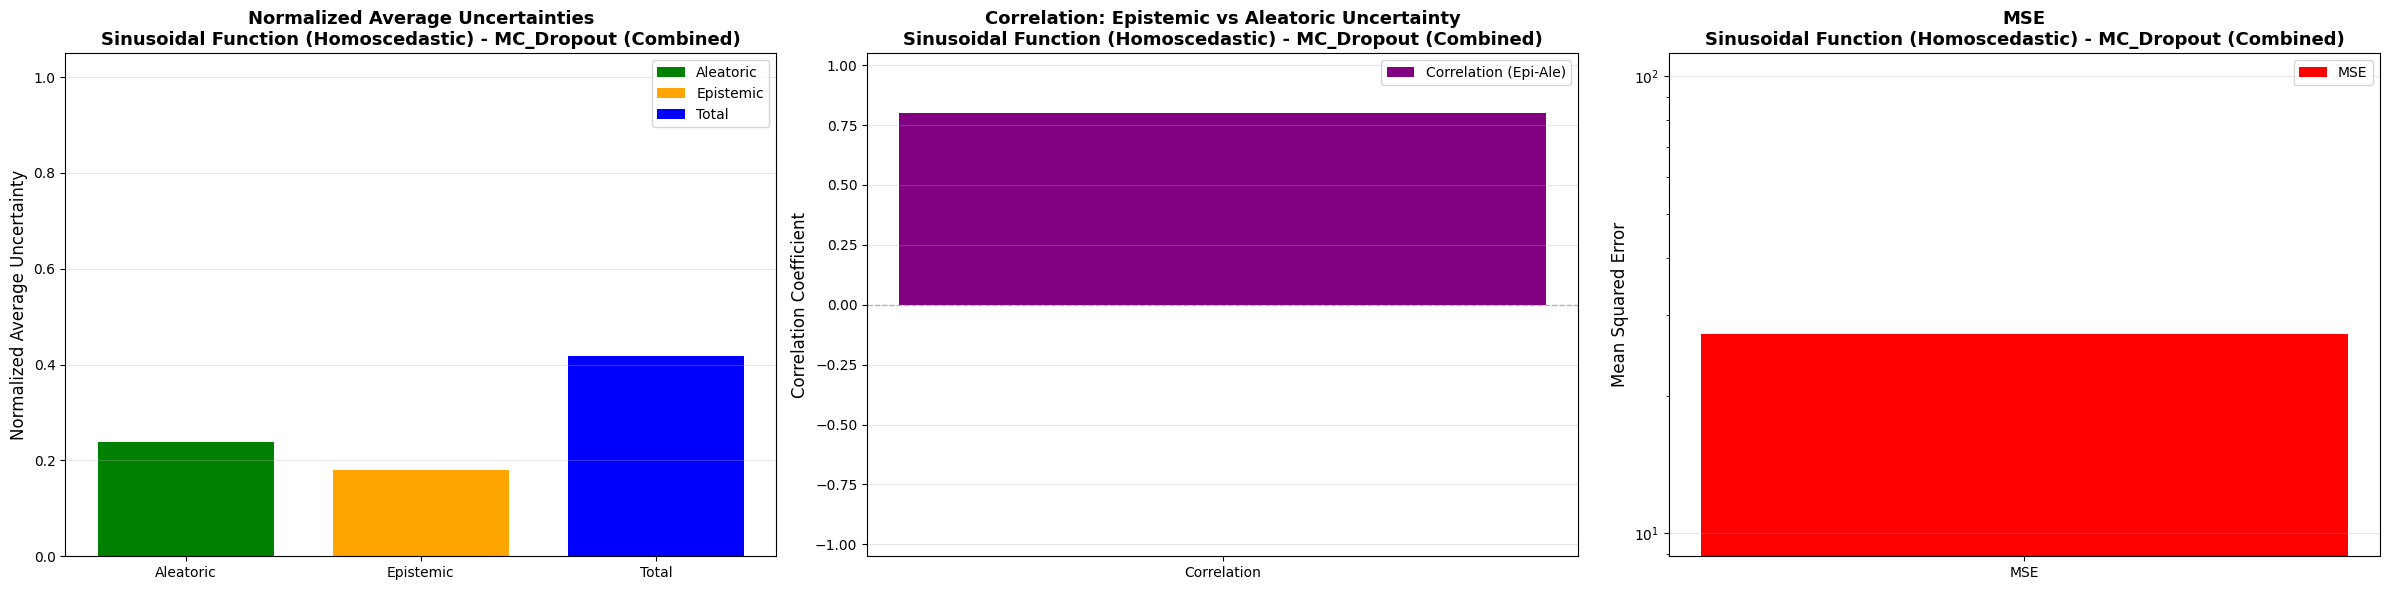


Note: Average values are normalized to [0, 1] range across all regions
      Correlation is computed on original (non-normalized) uncertainty values

OOD Experiment Statistics (Entropy) - Sinusoidal Function - MC_Dropout

Region       Avg Aleatoric (nats)      Avg Epistemic (nats)      Avg Total (nats)          Correlation (Epi-Ale)     MSE            
--------------------------------------------------------------------------------------------------------------------------------------------
ID                           2.401233                  0.008127                  2.409360                  0.308101         3.521137
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_ID_uncertainties_summary_Sinusoidal_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-eval

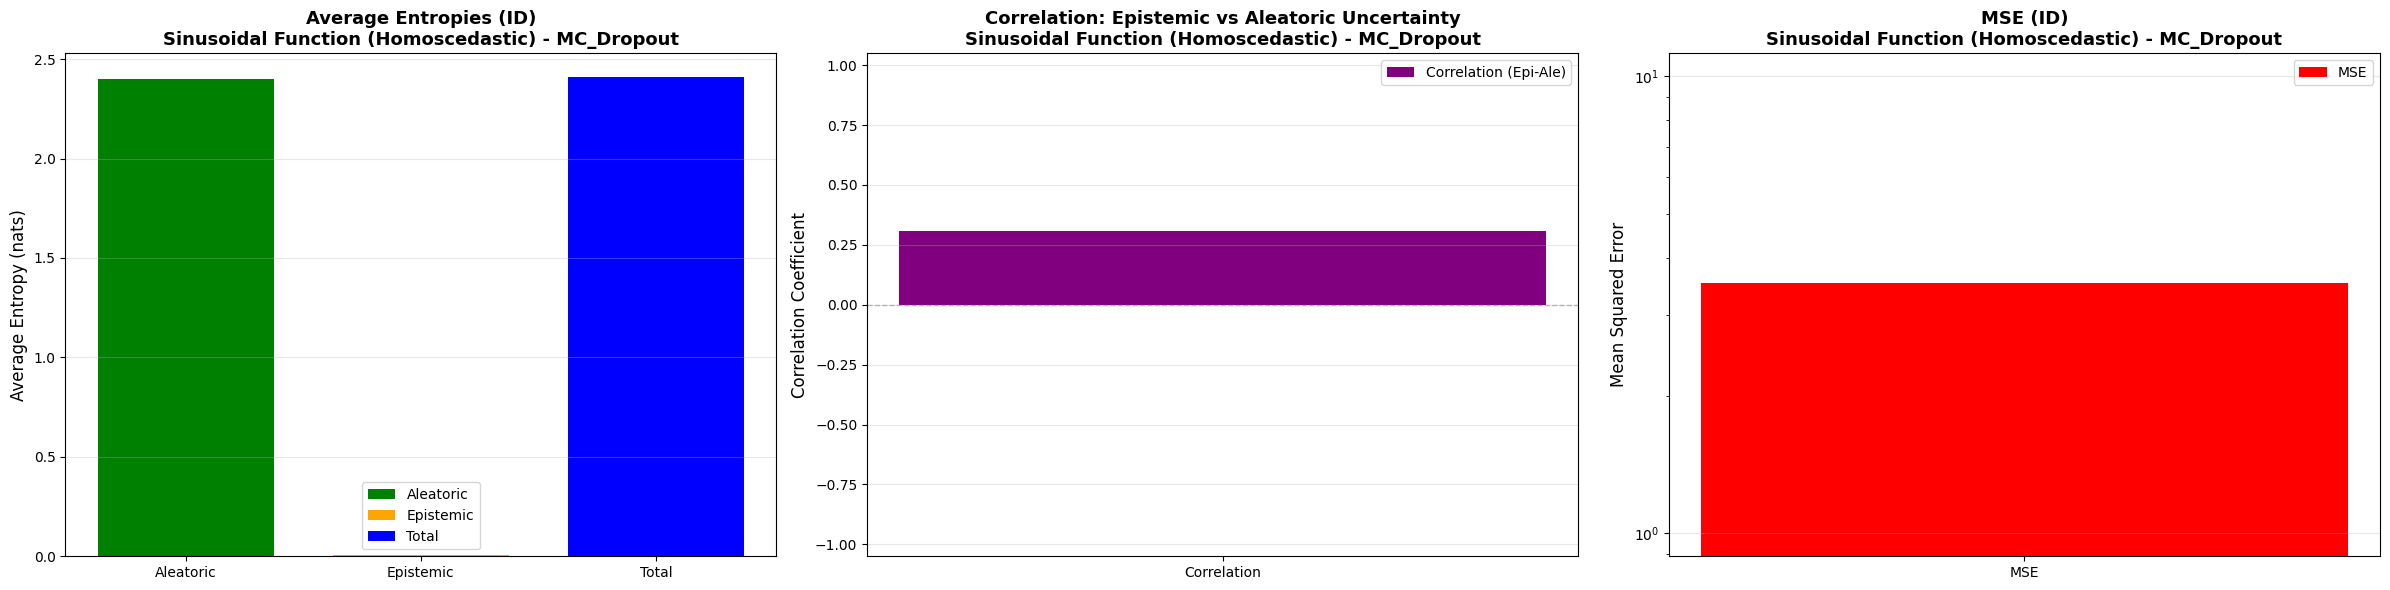

OOD                          3.158390                  0.014519                  3.172909                  0.347358        98.342804
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Sinusoidal_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Sinusoidal_homoscedastic_entropy.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_OOD_uncertainties_summary_Sinusoidal_homoscedastic_entropy.png


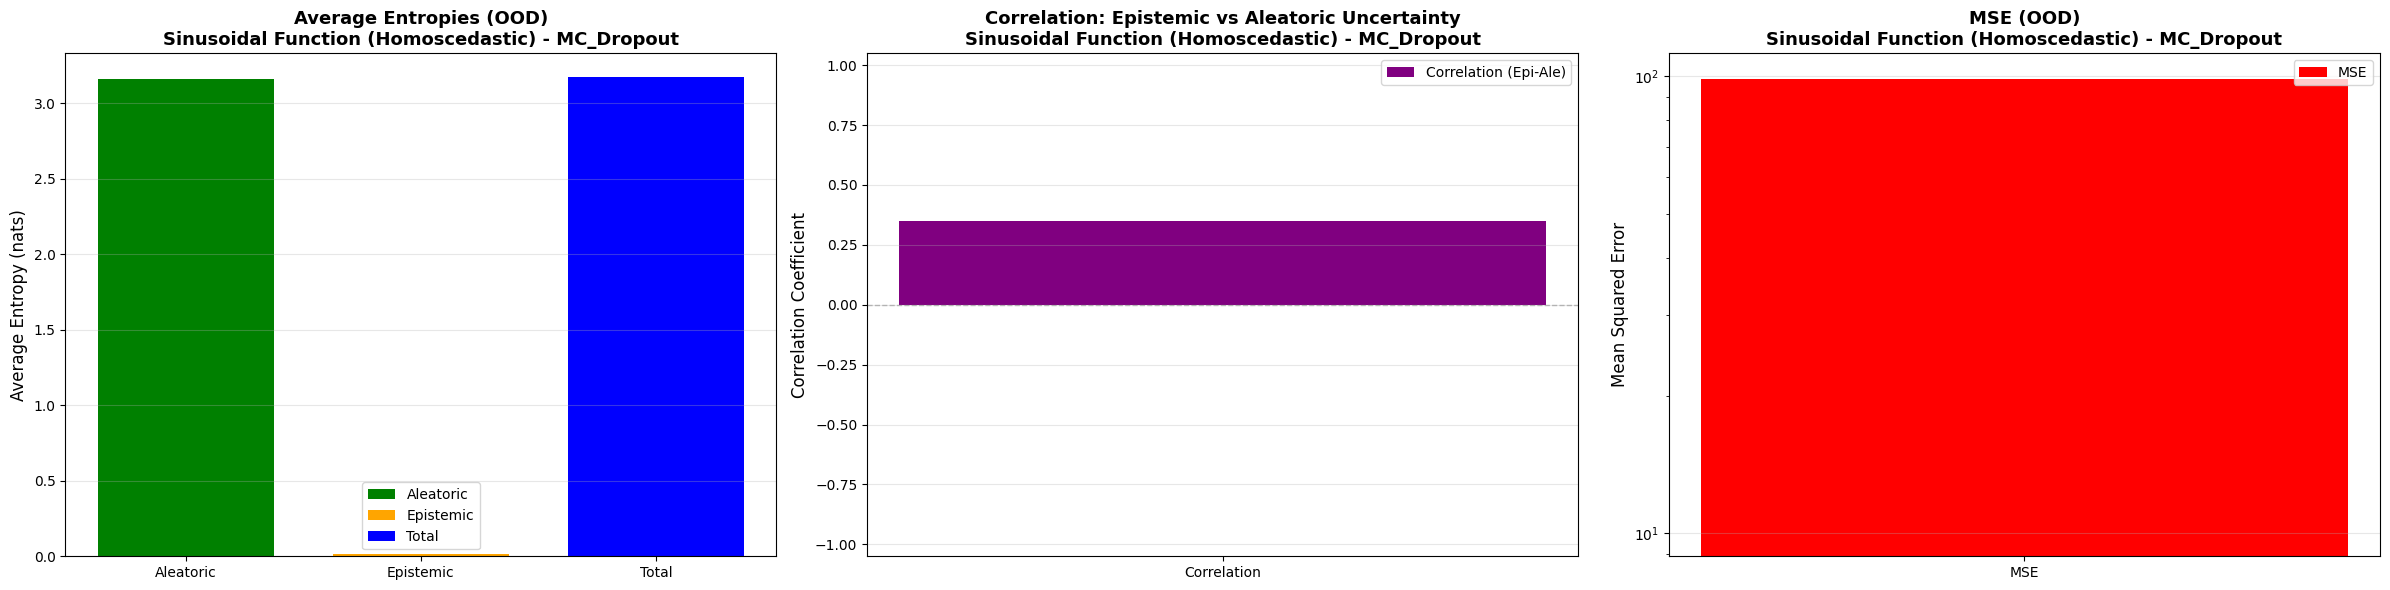

Combined                     2.590522                  0.009725                  2.600247                  0.415846        27.226553
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Sinusoidal_homoscedastic_entropy.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\statistics\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Sinusoidal_homoscedastic_entropy.xlsx
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\ood\plots\ood\homoscedastic\sin\20260103_MC_Dropout_p0.2_M20_Combined_uncertainties_summary_Sinusoidal_homoscedastic_entropy.png


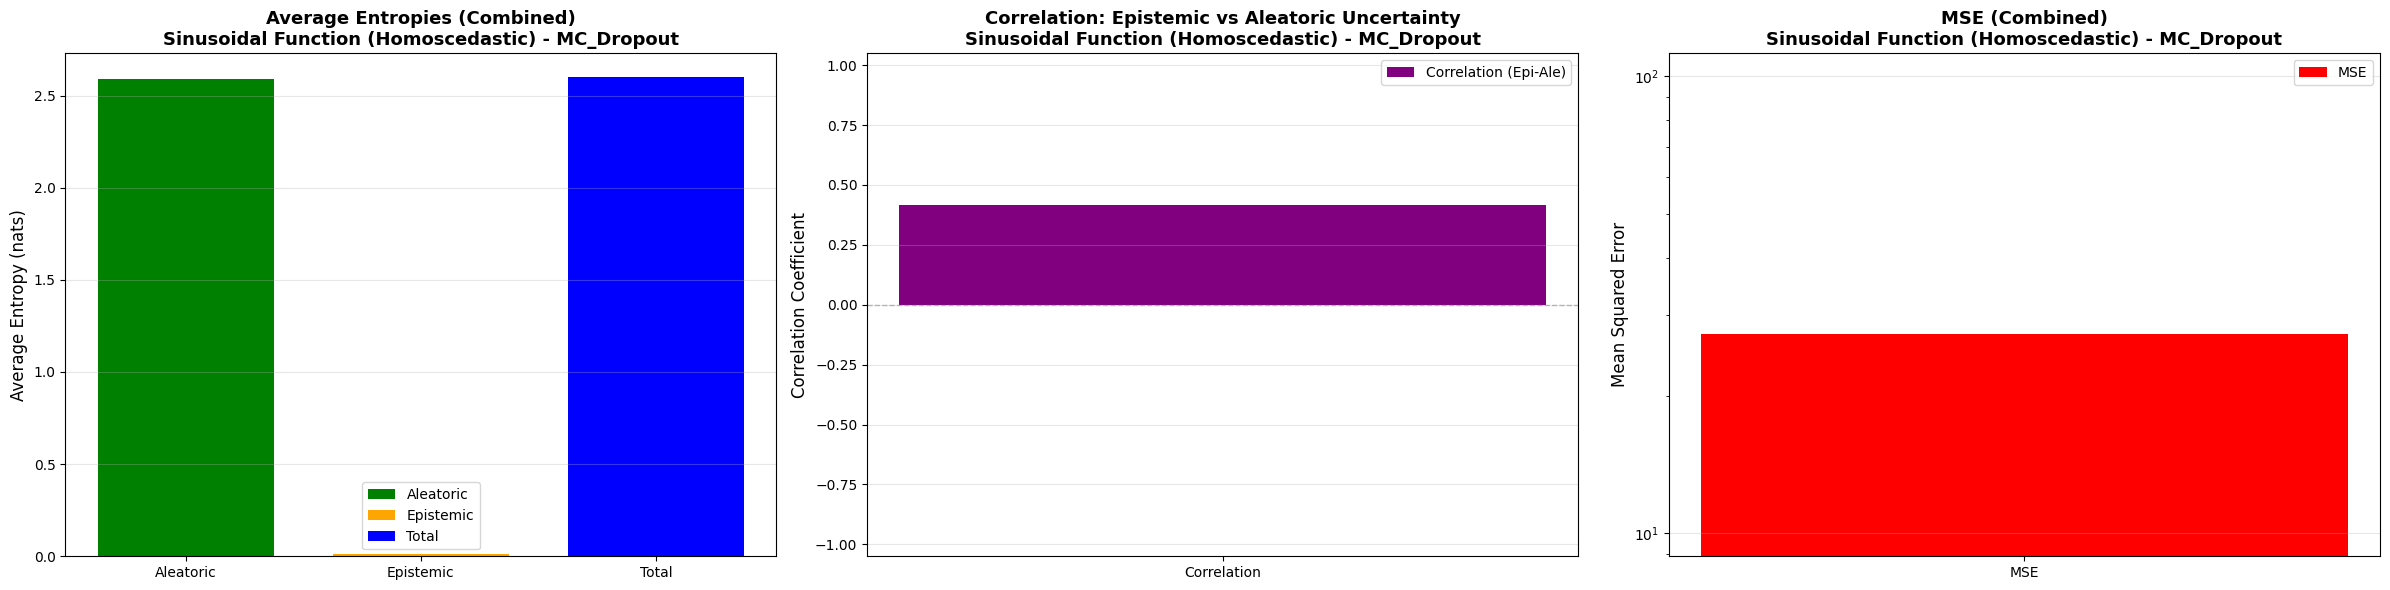


Note: Entropy values are in nats (natural logarithm base)
      Correlation is computed on entropy values


In [5]:
run_mc_dropout_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    p=0.2,
    beta=0.5,
    epochs=700,
    lr=1e-3,
    batch_size=32,
    mc_samples=20 
)


## MC Dropout - Heteroscedastic


In [ ]:
run_mc_dropout_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    p=0.2,
    beta=0.5,
    epochs=700,
    lr=1e-3,
    batch_size=32,
    mc_samples=20
)


## Deep Ensemble - Homoscedastic


In [ ]:
run_deep_ensemble_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    beta=0.5,
    batch_size=32,
    K=5
)


## Deep Ensemble - Heteroscedastic


In [ ]:
run_deep_ensemble_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    beta=0.5,
    batch_size=32,
    K=5
)


## BNN - Homoscedastic


In [ ]:
run_bnn_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    hidden_width=16,
    weight_scale=1.0,
    warmup=200,
    samples=200,
    chains=1
)


## BNN - Heteroscedastic


In [ ]:
run_bnn_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    hidden_width=16,
    weight_scale=1.0,
    warmup=200,
    samples=200,
    chains=1
)


## BAMLSS - Homoscedastic


In [ ]:
run_bamlss_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='homoscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    n_iter=12000,
    burnin=2000,
    thin=10,
    nsamples=1000
)


## BAMLSS - Heteroscedastic


In [ ]:
run_bamlss_ood_experiment(
    generate_toy_regression_func=generate_toy_regression,
    function_types=['linear', 'sin'],
    noise_type='heteroscedastic',
    train_range=train_range,
    ood_ranges=ood_ranges,
    n_train=n_train,
    grid_points=grid_points,
    seed=seed,
    n_iter=12000,
    burnin=2000,
    thin=10,
    nsamples=1000
)
